In [9]:
!pip install -q protobuf==4.21.12 python-dotenv scikit-learn pandas numpy==1.26.4 rank-bm25 nltk gensim matplotlib sentence-transformers openai requests transformers pillow torch chromadb langchain-text-splitters langchain_experimental langchain-huggingface pymupdf

In [10]:
import os

# Load environment variables
from dotenv import load_dotenv
load_dotenv("./.env")

False

# 1. Traditional IR Models

## 1.1 Vector Space Model

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

### TF-IDF

Prepare the sample corpus

In [12]:
documents = [
    "Information Retrieval is fun",
    "Retrieval is essential",
    "Fun AI"
]

Compute the TF-IDF matrix

In [13]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(documents)

Analyze the vocabulary

In [14]:
feature_names = vectorizer.get_feature_names_out()

print("\nFeature Names (Vocabulary):")
print(feature_names)



Feature Names (Vocabulary):
['ai' 'essential' 'fun' 'information' 'is' 'retrieval']


Display the TF-IDF matrix

In [15]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=[f"Doc {i+1}" for i in range(len(documents))])

print("TF-IDF Matrix:")
print(tfidf_df)

TF-IDF Matrix:
             ai  essential       fun  information        is  retrieval
Doc 1  0.000000   0.000000  0.459854     0.604652  0.459854   0.459854
Doc 2  0.000000   0.680919  0.000000     0.000000  0.517856   0.517856
Doc 3  0.795961   0.000000  0.605349     0.000000  0.000000   0.000000


### Cosine Similarity

Prepare the query vector

In [16]:
query = "fun"

query_vector = vectorizer.transform([query])

Compute the cosine similarity between the query and documents

In [17]:
cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()

similarity_df = pd.DataFrame({
    "Document": [f"Doc {i+1}" for i in range(len(documents))],
    "Cosine Similarity": cosine_similarities
}).sort_values(by="Cosine Similarity", ascending=False)

print("Cosine Similarity Between Query and Documents:")
print(similarity_df)

Cosine Similarity Between Query and Documents:
  Document  Cosine Similarity
2    Doc 3           0.605349
0    Doc 1           0.459854
1    Doc 2           0.000000


Find the most relevant document

In [18]:
most_relevant_idx = cosine_similarities.argmax()
print(f"\nMost Relevant Document: Doc {most_relevant_idx + 1}")



Most Relevant Document: Doc 3


## 1.2. Probabilistic Information Retrieval

In [19]:
from rank_bm25 import BM25Okapi

### BM25

Prepare the sample corpus

In [20]:
documents = [
    "Information Retrieval is fun",
    "Retrieval is essential",
    "Fun AI"
]

Tokenize the documents

_Note: The BM25 model requires tokenized documents. For simplicity, we will split the documents by whitespace. However, in practice, you may want to use more advanced tokenization techniques._

In [21]:
tokenized_documents = [doc.split() for doc in documents]

Train the BM25 model on the corpus

In [22]:
bm25 = BM25Okapi(tokenized_documents)

Prepare the query

In [23]:
query = "Fun Retrieval"

tokenized_query = query.split()

Compute the BM25 scores between the query and documents

In [24]:
bm25_scores = bm25.get_scores(tokenized_query)

score_df = pd.DataFrame({
    "Document": [f"Doc {i+1}" for i in range(len(documents))],
    "BM25 Score": bm25_scores
}).sort_values(by="BM25 Score", ascending=False)

print("BM25 Scores Between Query and Documents:")
print(score_df)

BM25 Scores Between Query and Documents:
  Document  BM25 Score
2    Doc 3    0.600971
1    Doc 2    0.054731
0    Doc 1    0.047592


Find the most relevant document

In [25]:
most_relevant_idx = bm25_scores.argmax()

print(f"\nMost Relevant Document: Doc {most_relevant_idx + 1}")


Most Relevant Document: Doc 3


## 1.3. Comparison

Prepare the sample corpus and query

In [26]:
documents = [
    "AI in healthcare improves diagnostics and patient care. AI algorithms analyze medical data to detect diseases early and enhance treatments",
    "AI enhances the e-commerce experience. AI systems recommend products, predict customer preferences, and increase sales. AI also personalizes online shopping",
    "Healthcare and AI are transforming diagnostics. Healthcare diagnostics benefit greatly from AI’s ability to process large datasets efficiently",
    "AI applications in healthcare include diagnostics, treatment planning, and patient monitoring. Healthcare systems increasingly rely on AI advancements",
    "AI in transportation is reshaping the future with self-driving cars, traffic optimization, and route planning. AI is making travel safer and more efficient"
]

query = "AI in healthcare diagnostics"

In [27]:
def tf_idf_retrieval(documents: list[str], query: str) -> int:
    """Compute cosine similarity between the query and documents using TF-IDF"""
    vectorizer = TfidfVectorizer()

    document_vectors = vectorizer.fit_transform(documents)
    query_vector = vectorizer.transform([query])

    cosine_similarities = cosine_similarity(query_vector, document_vectors).flatten()

    return cosine_similarities


def bm25_retrieval(documents: list[str], query: str) -> int:
    """Compute BM25 scores between the query and documents"""
    document_tokens = [doc.split() for doc in documents]

    bm25 = BM25Okapi(document_tokens)

    tokenized_query = query.split()

    bm25_scores = bm25.get_scores(tokenized_query)

    return bm25_scores


tf_idf_scores = tf_idf_retrieval(documents, query)
bm25_scores = bm25_retrieval(documents, query)

In [28]:
results_df = pd.DataFrame({
    "Document": [f"Doc {i+1}" for i in range(len(documents))],
    "BM25 Score": bm25_scores,
    "TF-IDF Score": tf_idf_scores
}).sort_values(by="BM25 Score", ascending=False).reset_index(drop=True)

print("Comparison of BM25 and TF-IDF Rankings:")
print(results_df)

print("\nOrder by BM25:")
print(results_df.sort_values(by="BM25 Score", ascending=False)["Document"].tolist())
print("\nOrder by TF-IDF:")
print(results_df.sort_values(by="TF-IDF Score", ascending=False)["Document"].tolist())

Comparison of BM25 and TF-IDF Rankings:
  Document  BM25 Score  TF-IDF Score
0    Doc 1    1.220365      0.364940
1    Doc 4    0.922859      0.482958
2    Doc 3    0.588048      0.457217
3    Doc 5    0.521071      0.151518
4    Doc 2    0.378244      0.129578

Order by BM25:
['Doc 1', 'Doc 4', 'Doc 3', 'Doc 5', 'Doc 2']

Order by TF-IDF:
['Doc 4', 'Doc 3', 'Doc 1', 'Doc 5', 'Doc 2']


#

# 2. The IR Process Workflow

## 2.1. Preprocessing

In [34]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Normalization

In [35]:
def normalize(text: str) -> str:
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

Apply normalization to the text and view the results

In [36]:
text = "Information     Retrieval is... FUN!!!"

print("Original Text:")
print(text)

normalized_text = normalize(text)

print("\nNormalized Text:")
print(normalized_text)

Original Text:
Information     Retrieval is... FUN!!!

Normalized Text:
information retrieval is fun


### Tokenization

In [37]:
def simple_split(doc: str) -> list[str]:
    """Split the document by whitespace"""
    return doc.split()

def word_tokenization(doc: str) -> list[str]:
    """Tokenize the document into words"""
    return word_tokenize(doc)

Tokenize the text and compare the results

In [38]:
text = "Dr. Smith said, 'Information Retrieval is fascinating!'"

print("Original Text:")
print(text)

tokens = simple_split(text)

print("\nSimple Split:")
print(tokens)

tokens = word_tokenization(text)

print("\nWord Tokenization:")
print(tokens)

Original Text:
Dr. Smith said, 'Information Retrieval is fascinating!'

Simple Split:
['Dr.', 'Smith', 'said,', "'Information", 'Retrieval', 'is', "fascinating!'"]

Word Tokenization:
['Dr.', 'Smith', 'said', ',', "'Information", 'Retrieval', 'is', 'fascinating', '!', "'"]


### Stop-word Removal

In [39]:
def remove_stop_words(tokens: list[str]) -> list[str]:
    """Remove stop-words from the list of tokens"""
    return [word for word in tokens if word not in stopwords.words('english')]

Remove stop-words from the tokens and view the results

In [40]:
tokens = ["this", "is", "an", "example", "of", "stop-word", "removal", "for", "information", "retrieval"]

print("Original Tokens:")
print(tokens)

filtered_tokens = remove_stop_words(tokens)

print("\nTokens after Stop-word Removal:")
print(filtered_tokens)

Original Tokens:
['this', 'is', 'an', 'example', 'of', 'stop-word', 'removal', 'for', 'information', 'retrieval']

Tokens after Stop-word Removal:
['example', 'stop-word', 'removal', 'information', 'retrieval']


### Stemming and Lemmatization

In [41]:
def apply_stemming(tokens: list[str]) -> list[str]:
    """Apply stemming to the list of tokens"""
    stemmer = PorterStemmer()

    return [stemmer.stem(word) for word in tokens]


def apply_lemmatization(tokens: list[str], pos: str = "n") -> list[str]:
    """Apply lemmatization to the list of tokens"""
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(word, pos=pos) for word in tokens]

Apply stemming and lemmatization to the tokens and compare the results

In [43]:
tokens = ["information", "retrieval", "makes", "retrieving", "information", "easier"]

print("Original Tokens:")
print(tokens)

stemmed_tokens = apply_stemming(tokens)

print("\nStemmed Tokens:")
print(stemmed_tokens)

lemmatized_tokens = apply_lemmatization(tokens)

print("\nLemmatized Tokens:")
print(lemmatized_tokens)

Original Tokens:
['information', 'retrieval', 'makes', 'retrieving', 'information', 'easier']

Stemmed Tokens:
['inform', 'retriev', 'make', 'retriev', 'inform', 'easier']


LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


Compare different POS tags for lemmatization

In [ ]:
print("Original Tokens:")
print(tokens)

lemmatized_v_tokens = apply_lemmatization(tokens, pos="v")

print("\nLemmatized Tokens (Verb):")
print(lemmatized_v_tokens)

lemmatized_a_tokens = apply_lemmatization(tokens, pos="a")

print("\nLemmatized Tokens (Adjective):")
print(lemmatized_a_tokens)


## 2.2. Retrieval & Ranking

In [ ]:
import numpy as np

### Similarity Metrics

In [ ]:
def euclidean_distance(v1: np.array, v2: np.array) -> float:
    """Compute the Euclidean distance between two vectors"""
    return np.linalg.norm(v1 - v2)

def dot_product(v1: np.array, v2: np.array) -> float:
    """Compute the dot product between two vectors"""
    return np.dot(v1, v2)

def cosine_similarity(v1: np.array, v2: np.array) -> float:
    """Compute the cosine similarity between two vectors"""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    return dot_product / (norm_v1 * norm_v2)

Prepare the sample vectors

In [ ]:
document_vectors = [
    np.array([1.1, 0.5, 0.2]),
    np.array([0.9, 0.4, 0.3]),
    np.array([0.8, 0.3, 0.4])
]

query_vector = np.array([0.8, 0.5, 0.2])

Compute the similarity metrics between the query and documents

In [ ]:
euclidean_distances = [euclidean_distance(query_vector, doc) for doc in document_vectors]
dot_products = [dot_product(query_vector, doc) for doc in document_vectors]
cosine_similarities = [cosine_similarity(query_vector, doc) for doc in document_vectors]

similarity_df = pd.DataFrame({
    "Document": [f"Doc {i+1}" for i in range(len(document_vectors))],
    "Euclidean Distance": euclidean_distances,
    "Dot Product": dot_products,
    "Cosine Similarity": cosine_similarities
})

print("Similarity Metrics:")
print(similarity_df)

print("\nOrder by Euclidean Distance:")
print(similarity_df.sort_values(by="Euclidean Distance")["Document"].tolist())

print("\nOrder by Dot Product:")
print(similarity_df.sort_values(by="Dot Product", ascending=False)["Document"].tolist())

print("\nOrder by Cosine Similarity:")
print(similarity_df.sort_values(by="Cosine Similarity", ascending=False)["Document"].tolist())

# 3. Embedding-Based Retrieval

## 3.1. Word Embeddings

In [50]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


### Computation

Prepare the sample corpus

In [48]:
corpus = [
    "Soccer is a popular sport worldwide.",
    "Football is known as soccer in many countries.",
    "I enjoy playing soccer with my friends.",
    "Football matches are fun to watch."
]

normalized_corpus = [normalize(doc) for doc in corpus]
tokenized_corpus = [word_tokenization(doc) for doc in normalized_corpus]
filtered_corpus = [remove_stop_words(tokens) for tokens in tokenized_corpus]

Train the Word2Vec model on the corpus

In [51]:
def get_word_embeddings(corpus: list[list[str]]) -> tuple[np.array, list[str]]:
    """Train a Word2Vec model on the corpus"""
    model = Word2Vec(corpus, vector_size=10, window=2, min_count=1, sg=0)

    words = list(model.wv.key_to_index)  # Vocabulary words
    word_vectors = model.wv[words]  # Corresponding embeddings

    return word_vectors, words

In [52]:
word_embeddings, words = get_word_embeddings(filtered_corpus)

print("Word Embeddings Shape:", word_embeddings.shape)

Word Embeddings Shape: (14, 10)


### Visualization

Reduce the dimensions of the embeddings for visualization using PCA

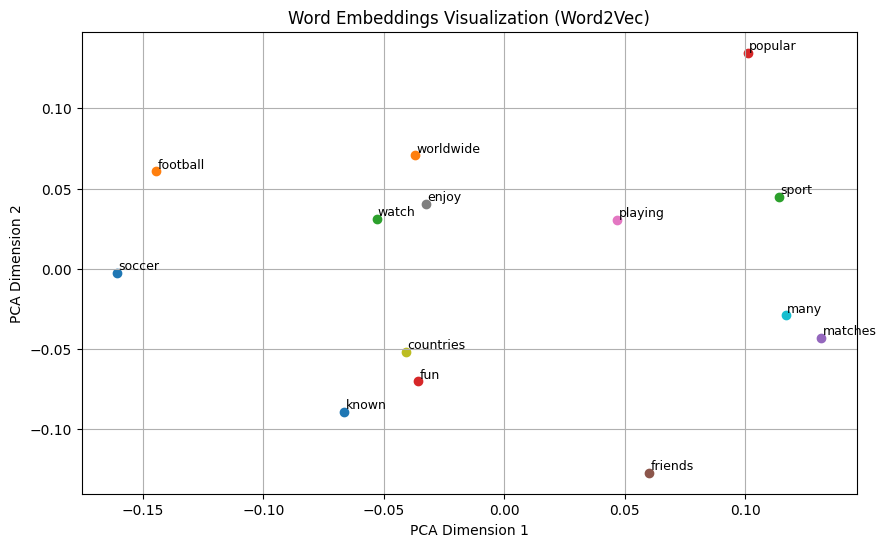

In [53]:
# Reduce Dimensions for Visualization (2D)
pca = PCA(n_components=2)
reduced_word_vectors = pca.fit_transform(word_embeddings)

# Plot Word Embeddings
plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    x, y = reduced_word_vectors[i]
    plt.scatter(x, y)
    plt.text(x + 0.0005, y + 0.002, word, fontsize=9)

plt.title("Word Embeddings Visualization (Word2Vec)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid()
plt.show()

## 3.3. Sentence Embeddings

### Computation

In [54]:
from sentence_transformers import SentenceTransformer

Prepare the sample sentences

In [55]:
sentences = [
    "Information Retrieval is fascinating",
    "Retrieval systems retrieve documents",
    "I love playing football",
    "Soccer is a great sport",
    "Cooking is an enjoyable activity",
    "Baking is part of cooking",
    "A lovely day for a picnic",
    "Cats are beautiful animals"
]

Compute the embeddings for the sentences

In [56]:
def get_sentence_embeddings(sentences: list[str]) -> np.array:
    """Compute embeddings for the list of sentences"""
    model = SentenceTransformer('all-MiniLM-L6-v2')

    return model.encode(sentences)

In [57]:
sentence_embeddings = get_sentence_embeddings(sentences)

print("Embeddings Shape:", sentence_embeddings.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings Shape: (8, 384)


### Visualization

Reduce the dimensions of the embeddings for visualization using PCA

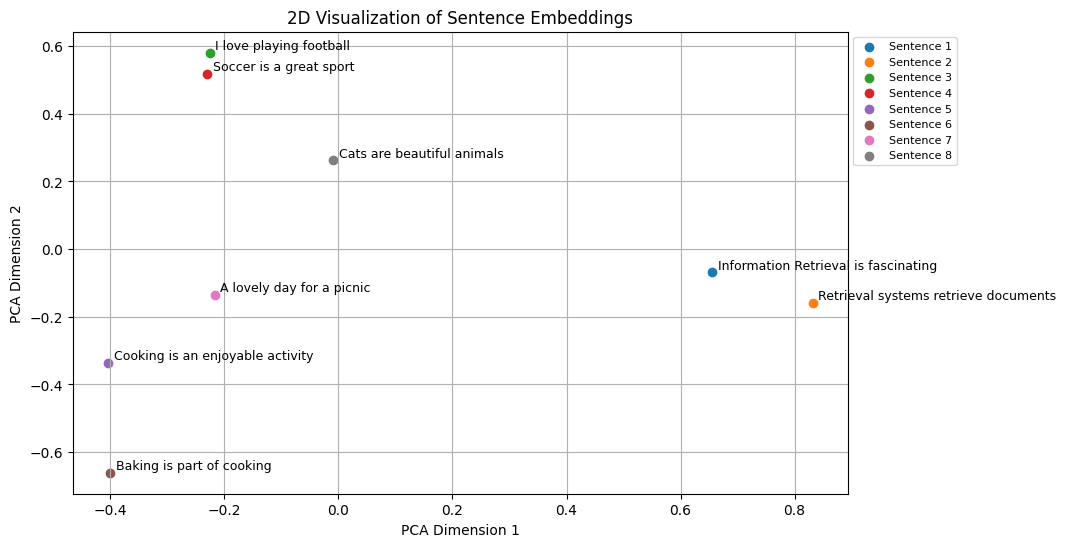

In [58]:
# Reduce Dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sentence_embeddings)

# Plot the Embeddings
plt.figure(figsize=(10, 6))
for i, sentence in enumerate(sentences):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, label=f"Sentence {i+1}")
    plt.text(x + 0.01, y + 0.01, sentence, fontsize=9)

plt.title("2D Visualization of Sentence Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid()
plt.show()

## 3.3. GPT Embeddings

In [59]:
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

### Computation

Prepare the sample sentences

In [60]:
documents = [
    "AI is the future of technology",
    "The world is becoming more digital",
    "Data science is the key to innovation",
    "Remote work is the new normal",
    "OpenAI provides powerful tools for developers",
    "I like to code in Python"
]

In [61]:
def get_gpt_embedding(documents: list[str]) -> np.array:
    """Compute embeddings for the list of documents usng GPT"""
    response = openai.embeddings.create(
        model="text-embedding-ada-002",
        input=documents
    )

    return np.array([embedding.embedding for embedding in response.data])

Compute the embeddings for the documents

In [62]:
gpt_embeddings = get_gpt_embedding(documents)

print("Embeddings Shape:", gpt_embeddings.shape)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

### Visualization

In [ ]:
# Reduce Dimensions to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(gpt_embeddings)

# Visualize the Embeddings
plt.figure(figsize=(10, 6))
for i, sentence in enumerate(documents):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, label=f"Sentence {i+1}")
    plt.text(x + 0.01, y + 0.01, sentence, fontsize=9)

plt.title("2D Visualization of Sentence Embeddings (GPT)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid()
plt.show()

## 3.4. Image Embeddings

### Computation

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests

Prepare the sample images

In [ ]:
images = [
    "https://images.unsplash.com/2/03.jpg",
    "https://images.unsplash.com/2/01.jpg",
    "https://images.unsplash.com/2/06.jpg",
    "https://images.unsplash.com/2/09.jpg"
]

def download_image(url: str) -> Image:
    """Download and return the image from the URL"""
    return Image.open(requests.get(url, stream=True).raw)

# Display Images
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
for i, image_url in enumerate(images):
    image = download_image(image_url)
    axs[i].imshow(image)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

plt.show()


Compute the embeddings for the images using the CLIP model

In [ ]:
def get_clip_image_embeddings(images: list[str]) -> np.array:
    """Compute embeddings for the list of images using CLIP"""
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    image_embeddings = []

    for image_url in images:
        image = download_image(image_url)
        inputs = processor(images=image, return_tensors="pt")
        outputs = model.get_image_features(**inputs)

        image_embeddings.append(outputs.detach().numpy().flatten())

    return np.array(image_embeddings)

In [ ]:
image_embeddings = get_clip_image_embeddings(images)

print("Embeddings Shape:", image_embeddings.shape)

### Visualization

In [ ]:
# Reduce Dimensions to 2D
pca = PCA(n_components=2)
reduced_image_embeddings = pca.fit_transform(image_embeddings)

# Visualize the Embeddings
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(reduced_image_embeddings):
    plt.scatter(x, y, label=f"Image {i+1}")
    plt.text(x + 0.01, y + 0.01, f"Image {i+1}", fontsize=9)

plt.title("2D Visualization of Image Embeddings (CLIP)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.grid()
plt.show()

## 3.5 Cross-Modal Retrieval

### Computation

Prepare the images and query

In [ ]:
images = [
    "https://images.unsplash.com/photo-1588770878098-90fac9857313",
    "https://images.unsplash.com/photo-1574217177748-deb9b741bc5a",
    "https://images.unsplash.com/photo-1534347772883-c3c228d654e1"
]
query = "Dog eating food"

# Display Images
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
for i, image_url in enumerate(images):
    image = download_image(image_url)
    axs[i].imshow(image)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

Compute the embeddings for the images and query

In [ ]:
def get_clip_text_embeddings(text: str) -> np.array:
    """Compute embeddings for the text using CLIP"""
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    text_inputs = processor(text=text, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**text_inputs).detach().numpy()

    return text_features

In [ ]:
image_embeddings = get_clip_image_embeddings(images)
query_embedding = get_clip_text_embeddings(query)

Compute the similarity between the query and images

In [ ]:
similarities = np.dot(query_embedding, image_embeddings.T).flatten()  # Dot product for similarity

### Results

In [ ]:
print("Text-to-Image Similarities:")
for i, similarity in enumerate(similarities):
    print(f"Similarity with Image {i+1}: {similarity:.4f}")

most_similar_idx = np.argmax(similarities)
print(f"\nMost Similar Image: Image {most_similar_idx + 1}")

#

# 4. Vector Database

## 4.1. ChromaDB

In [ ]:
from chromadb import Client

### Create Index

Prepare the sample documents and vector embeddings

In [ ]:
documents = [
    "AI is the future of technology",
    "The world is becoming more digital",
    "Data science is the key to innovation",
    "Remote work is the new normal",
    "OpenAI provides powerful tools for developers",
    "I like to code in Python"
]

Set up the ChromaDB client and create a collection that stores embeddings

In [ ]:
index_name = "NAI"

chromadb_client = Client()

# Check if the index exists and delete it
if index_name in [i.name for i in chromadb_client.list_collections()]:
    chromadb_client.delete_collection(index_name)

index = chromadb_client.create_collection(
    name=index_name,
    metadata={"hnsw:space": "cosine"}  # Use cosine similarity for retrieval (default is Euclidean)
)

### Insert Documents

In [ ]:
index.add(documents=documents, ids=[f"{i}" for i in range(len(documents))])

### Retrieve Documents

Prepare the query

In [ ]:
query = "What is the future of technology?"

In [ ]:
results = index.query(query_texts=[query], n_results=3)

results_df = pd.DataFrame({
    "Document": results["documents"][0],
    "Distance": results["distances"][0]
})

print("Query Results:")
print(results_df)

#

# 5. Chunking

## 5.1. Fixed-Length Chunking

In [63]:
from langchain_text_splitters import CharacterTextSplitter

### Split Text

Prepare the sample text

In [64]:
document = "This is a sample document for text chunking. The text will be split into smaller chunks of fixed length."

Split the text into fixed-length chunks

In [65]:
text_splitter = CharacterTextSplitter(
    # Set a really small chunk size, just to show
    chunk_size=30,
    chunk_overlap=10,
    separator=' ',
)

chunks = text_splitter.split_text(document)

print("Chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk}")

Chunks:
Chunk 1: This is a sample document for
Chunk 2: for text chunking. The text
Chunk 3: The text will be split into
Chunk 4: split into smaller chunks of
Chunk 5: chunks of fixed length.


## 5.2. Content-Based Chunking

### Split Text

Prepare the sample text

In [ ]:
text = """
This is a sample document for recursive text chunking. The text will be split into smaller chunks based on the logical structure of the content.

The process involves recursively splitting the text into smaller chunks, ensuring that the content is divided based on sentences and paragraphs.
"""

Split the text into content-based chunks

In [ ]:
text_splitter = CharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=5,
    separator='.'  # '\n' for paragraphs
)

chunks = text_splitter.create_documents([text])

print("Chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk.page_content}")

## 5.3. Semantic Chunking

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_huggingface import HuggingFaceEmbeddings

### Split Text

Prepare the sample text

In [ ]:
text = (
    "This is a sample document for semantic text chunking. "
    "The text will be split into smaller chunks based on semantic similarity. "
    "And this is another sentence. Cats are beautiful animals. "
    "The quick brown fox jumps over the lazy dog."
)

Split the text into semantically similar chunks

In [ ]:
text_splitter = SemanticChunker(HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2"))

chunks = text_splitter.split_text(text)

print("Chunks:")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}: {chunk}")

#

# 6. End-to-End IR System

## 6.1. Load Data

In [ ]:
import fitz
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Extract Text and Images

In [ ]:
def extract_text(pdf_path: str) -> tuple[str, list[bytes]]:
    """Extracts text and images from a PDF file."""
    doc = fitz.open(pdf_path)

    text = ""

    for page in doc:
        text += page.get_text()

    return text

In [ ]:
file_path = "./cookbook.pdf"

text = extract_text(file_path)

### Chunk Text

In [ ]:
def chunk_text(text: str, chunk_size: int, chunk_overlap: int) -> list[str]:
    """Chunk the text into smaller segments based on the specified chunk size and overlap."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )

    chunks = splitter.split_text(text)

    return chunks


In [ ]:
text_chunks = chunk_text(text, chunk_size=1000, chunk_overlap=100)

## 6.2. Indexing

### Create Index

In [ ]:
def create_index(index_name: str) -> Client:
    """Create a ChromaDB index and add the documents."""
    chromadb_client = Client()

    # Check if the index exists and delete it
    if index_name in [i.name for i in chromadb_client.list_collections()]:
        chromadb_client.delete_collection(index_name)

    index = chromadb_client.create_collection(
        name=index_name,
        metadata={"hnsw:space": "cosine"}
    )

    return index

In [ ]:
index_name = "Cookbook"

index = create_index(index_name=index_name)

### Get Embeddings

In [ ]:
text_embeddings = get_gpt_embedding(text_chunks)

### Insert Embeddings

In [ ]:
index.add(
    embeddings=text_embeddings,
    documents=text_chunks,
    ids=[f"if_{i+1}" for i in range(len(text_chunks))]
)

## 6.3. Querying

In [ ]:
query = "How can I make Margherita Pizza Quesadillas?"

In [ ]:
query_embedding = get_gpt_embedding([query])

results = index.query(query_embeddings=query_embedding, n_results=10)

In [ ]:
for doc in results["documents"][0]:
    print(doc)
    print("-"*50)